In [1]:
import os 
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

/srv/ds_project/Indra_proj/dsp_gamification_experiment


In [2]:
# Import modules 

import os 
import itertools
from IPython.display import display

from credential_accessor import CredentialAccessor 
from dao.google_bigquery import GoogleBigQuery as gbq 

creds_accessor = CredentialAccessor(env = "prod", on_server= False)
myGBQ = gbq(attr = creds_accessor.get_attr())


from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

import json

import joblib 


import pandas as pd 
import numpy as np 


import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import CompareMeans
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import chi2_contingency
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('bmh')
%matplotlib inline

In [3]:
query_dependency = """

with list_pareto as (
select cluster, prd_id 
from mp_ref.mp_ref_pareto_sku_ae_ter pareto 
where pareto.input_date = "{pareto_snapshot_dt}"
group by 1,2
),


tab_trx_assortment as (
select v2v.mitra_id, v2v.cluster,
sum(mmod.gmv) total_gmv_assortment, count(distinct mmod.str_trx_id) total_trx_assortment, count(distinct trx_prd_id) total_prd_assortment
from mp_bi.mp_bi_fact_mitra_v2v v2v
left join mp_mst.mp_mst_order_details mmod on v2v.mitra_id = mmod.mitra_id 
left join list_pareto pareto on pareto.prd_id = mmod.trx_prd_id and v2v.cluster = pareto.cluster 
where mmod.trx_status = "COMPLETED" and date(mmod.trx_created_at) >= "{start_date}" and date(mmod.trx_created_at) <= "{end_date}"
and v2v.province = "JAWA BARAT" and v2v.cluster is not null and pareto.prd_id is not null
group by 1,2),

tab_trx_nonassortment as (
select v2v.mitra_id, v2v.cluster,
sum(mmod.gmv) total_gmv_nonassortment, count(distinct mmod.str_trx_id) total_trx_nonassortment, count(distinct trx_prd_id) total_prd_nonassortment
from mp_bi.mp_bi_fact_mitra_v2v v2v
left join mp_mst.mp_mst_order_details mmod on v2v.mitra_id = mmod.mitra_id 
left join list_pareto pareto on pareto.prd_id = mmod.trx_prd_id and v2v.cluster = pareto.cluster 
where mmod.trx_status = "COMPLETED" and date(mmod.trx_created_at) >= "{start_date}" and date(mmod.trx_created_at) <= "{end_date}"
and v2v.province = "JAWA BARAT" and v2v.cluster is not null and pareto.prd_id is null
group by 1,2
),

tab_trx as (
select v2v.mitra_id,
v2v.cluster,
tta.total_gmv_assortment,
tta.total_trx_assortment,
tta.total_prd_assortment,
ttn.total_gmv_nonassortment,
ttn.total_trx_nonassortment,
ttn.total_prd_nonassortment,
count(distinct mmod.str_trx_id) total_trx, 
sum(mmod.gmv) total_gmv
from mp_bi.mp_bi_fact_mitra_v2v v2v 
left join tab_trx_assortment tta on v2v.mitra_id = tta.mitra_id
left join tab_trx_nonassortment ttn on v2v.mitra_id = ttn.mitra_id
left join mp_mst.mp_mst_order_details mmod on v2v.mitra_id = mmod.mitra_id 
where mmod.trx_status = "COMPLETED" and date(mmod.trx_created_at) >= "{start_date}" and date(mmod.trx_created_at) <= "{end_date}"
and v2v.province = "JAWA BARAT" and v2v.cluster is not null
group by 1,2,3,4,5,6,7,8
),

tab_app_usage_details as (
select  v2v.mitra_id, pa.event_date, pa.session_id, DATETIME_DIFF(max(pa.event_timestamp),min(pa.event_timestamp), SECOND) duration_s
from pa_stg.pa_stg_mitra_events pa
left join mp_mst.mp_mst_mitra_details mmmd on mmmd.user_id = pa.aa_user_id 
left join mp_bi.mp_bi_fact_mitra_v2v v2v on v2v.mitra_id = mmmd.mitra_id 
where date(event_date) >= "{start_date}" and date(event_date) <= "{end_date}" and aa_user_id is not null and pa.event_timestamp is not null and pa.session_id is not null and v2v.province = "JAWA BARAT" and v2v.cluster is not null
group by 1,2,3
having DATETIME_DIFF(max(event_timestamp),min(event_timestamp), SECOND) <= 1800 and DATETIME_DIFF(max(event_timestamp),min(event_timestamp), SECOND) > 0
),

tab_app_usage as (
select app_usage.mitra_id, count(distinct app_usage.event_date) day_open, count(distinct app_usage.session_id) times_open, sum(app_usage.duration_s) total_duration
from tab_app_usage_details app_usage
group by 1)

select v2v.mitra_id, 
v2v.cluster,
dep.label, 
lrfm.parent_label,
lrfm.monetary l3m_total_gmv,
lrfm.frequency l3m_total_trx,

app_usage.day_open,
app_usage.times_open,
app_usage.total_duration,

tt.total_gmv_assortment,
tt.total_trx_assortment,
tt.total_prd_assortment,
tt.total_gmv_nonassortment,
tt.total_trx_nonassortment,
tt.total_prd_nonassortment,
tt.total_trx, 
tt.total_gmv

from mp_bi.mp_bi_fact_mitra_v2v v2v 
left join mp_bi.mp_bi_fact_dependency_mitra dep on dep.mitra_id = v2v.mitra_id and date(dep.dt_snapshot) = "{snapshot_dt}"
left join mp_bi.mp_bi_fact_mitra_lrfm_segmentation lrfm on lrfm.mitra_id = v2v.mitra_id and date(month_id) = "{snapshot_dt}"
left join tab_app_usage app_usage on app_usage.mitra_id = v2v.mitra_id
left join tab_trx tt on tt.mitra_id = v2v.mitra_id
where dep.label in ('AE Device','Independent','Dependent') and v2v.province = "JAWA BARAT" and v2v.cluster is not null
and lrfm.parent_label is not null

"""

dependency_April : pd.DataFrame = myGBQ.gbq_read(
    query_dependency.format(
    start_date = "2024-04-01",
    end_date = "2024-04-29",
    snapshot_dt = "2024-04-01",
    pareto_snapshot_dt = "04/01/2024")
)

dependency_April['snapshot_dt'] = "2024-04-01"

dependency_May : pd.DataFrame = myGBQ.gbq_read(
    query_dependency.format(
    start_date = "2024-05-06",
    end_date = "2024-05-27",
    snapshot_dt = "2024-05-01",
    pareto_snapshot_dt = "05/01/2024")
)

dependency_May['snapshot_dt'] = "2024-05-01"

dependency_df : pd.DataFrame = pd.concat([dependency_April,dependency_May],axis=0).reset_index(drop=True)

dependency_df = dependency_df.fillna(0)

In [25]:
gami_May : pd.DataFrame = pd.read_csv(
    os.path.join(os.getcwd(),'datasets','QuizSolved_05.csv')
)
gami_April : pd.DataFrame = pd.read_csv(
    os.path.join(os.getcwd(),'datasets','QuizSolved_04.csv')
)

gami_df : pd.DataFrame = pd.concat([gami_April,gami_May],axis=0).reset_index(drop=True)



full_df : pd.DataFrame = dependency_df.merge(gami_df,how="left",left_on = ['mitra_id','snapshot_dt'], right_on = ['mitra_id','pareto_snapshot_dt'])

full_df['NumQuizSolved'] = full_df['NumQuizSolved'].fillna(0)
full_df['play_game'] = full_df.NumQuizSolved.apply(lambda x: 'Yes' if x > 0 else 'No')
full_df

,mitra_id,cluster,label,parent_label,l3m_total_gmv,l3m_total_trx,day_open,times_open,total_duration,total_gmv_assortment,...,total_prd_assortment,total_gmv_nonassortment,total_trx_nonassortment,total_prd_nonassortment,total_trx,total_gmv,snapshot_dt,NumQuizSolved,pareto_snapshot_dt,play_game
0,35226,PRIANGAN TIMUR,AE Device,Churn,0.0,0,1,1,207,0.0,...,0,0.0,0,0,0,0.0,2024-04-01,0.0,NaN,No
1,8832,BOCIMI,Independent,Potential,7042500.0,1,4,6,2106,0.0,...,0,0.0,0,0,0,0.0,2024-04-01,0.0,NaN,No
2,34178,PRIANGAN TIMUR,AE Device,Low Value,1837239.0,3,0,0,0,0.0,...,0,0.0,0,0,0,0.0,2024-04-01,0.0,NaN,No
3,34117,PRIANGAN TIMUR,AE Device,Low Value,2180480.0,2,1,2,71,650000.0,...,1,0.0,0,0,1,650000.0,2024-04-01,0.0,NaN,No
4,34065,PRIANGAN TIMUR,AE Device,Low Value,704000.0,1,1,1,1632,619430.0,...,2,0.0,0,0,1,619430.0,2024-04-01,0.0,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,54177,CIAYUMAJAKUNING,Independent,Potential,11060599.0,9,10,15,5897,689038.0,...,1,676378.0,1,1,1,1365416.0,2024-05-01,0.0,NaN,No
4231,34490,CIAYUMAJAKUNING,Dependent,Low Value,1809080.0,1,4,4,1017,1507260.0,...,1,0.0,0,0,1,1507260.0,2024-05-01,0.0,NaN,No
4232,25656,CIAYUMAJAKUNING,Dependent,Churn,0.0,0,1,1,486,10536438.0,...,2,0.0,0,0,1,10536438.0,2024-05-01,0.0,NaN,No
4233,42063,CIAYUMAJAKUNING,Independent,Potential,11621700.0,3,4,4,2003,1591200.0,...,1,0.0,0,0,1,1591200.0,2024-05-01,1.0,2024-05-01,Yes


#### Analyze how many mitra are participating the game

In [26]:
for time_ in ['2024-04-01','2024-05-01'] : 
    print(f"for snapshot : {time_}")
    print(full_df[full_df.snapshot_dt == time_].value_counts('play_game'))

for snapshot : 2024-04-01
play_game
No     1665
Yes     493
Name: count, dtype: int64
for snapshot : 2024-05-01
play_game
No     1600
Yes     477
Name: count, dtype: int64


In [28]:
def calculate_ttest(
    d1 : pd.Series,
    d2 : pd.Series
) -> float :
    pval  = ttest_ind(d1,d2,usevar = 'unequal',alternative='larger')[1]
    return pval

def calculate_ztest(
    d1 : pd.Series,
    d2 : pd.Series
) -> float :
    d1 = DescrStatsW(d1)
    d2 = DescrStatsW(d2)
    res = CompareMeans(d1,d2)
    pval  = res.ztest_ind(usevar='unequal',alternative='larger')[1]
    return pval

def calculate_chisq(
    base: pd.Series,
    target : pd.Series) -> float : 
    
    crosstab_ = pd.crosstab(base,target)
    X2, p, dof, expected = chi2_contingency(crosstab_.values)
    
    N = np.sum(crosstab_.values)
    minimum_dimension = min(crosstab_.values.shape)-1
    
    # Calculate Cramer's V 
    cramV = np.sqrt((X2/N) / minimum_dimension) 
    return p,cramV,X2,dof
    

#### Analyze the screening time, day_play, and session_times 

snapshot_dt : 2024-04-01
base : play_game
target : total_duration
Mean Yes : 12870.2
Mean No : 5208.37
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_duration
Mean Yes : 11631.29
Mean No : 5479.49
pval ttest = 0.0
pval ztest = 0.0



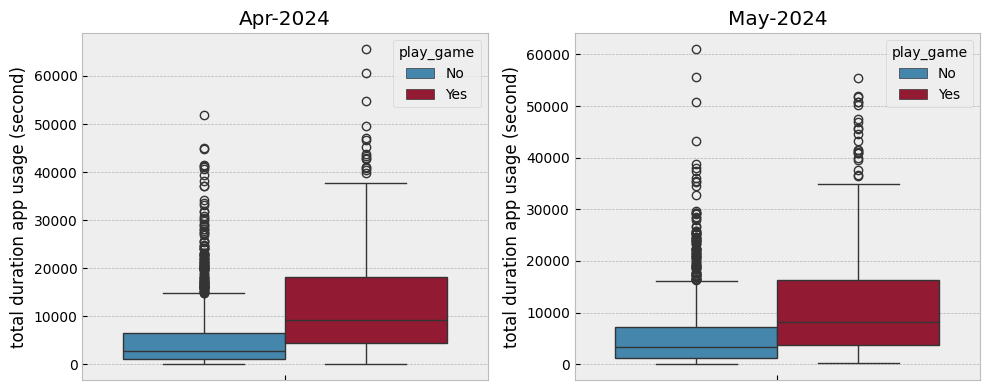

In [38]:

base_feature = 'play_game'
target_feature = 'total_duration'
feature_name = "total duration app usage (second)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[full_df['snapshot_dt'] == time_].copy()
    temp_df = temp_df[temp_df.times_open>0]
    
    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : day_open
Mean Yes : 15.36
Mean No : 8.14
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : day_open
Mean Yes : 13.44
Mean No : 8.3
pval ttest = 0.0
pval ztest = 0.0



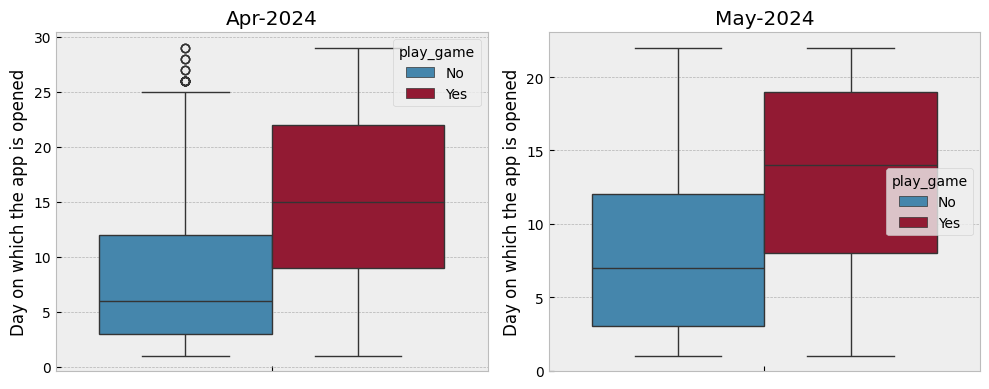

In [42]:

base_feature = 'play_game'
target_feature = 'day_open'
feature_name = "Day on which the app is opened"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[full_df['snapshot_dt'] == time_].copy()
    temp_df = temp_df[temp_df.times_open>0]
    
    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : times_open
Mean Yes : 34.96
Mean No : 14.7
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : times_open
Mean Yes : 31.27
Mean No : 14.87
pval ttest = 0.0
pval ztest = 0.0



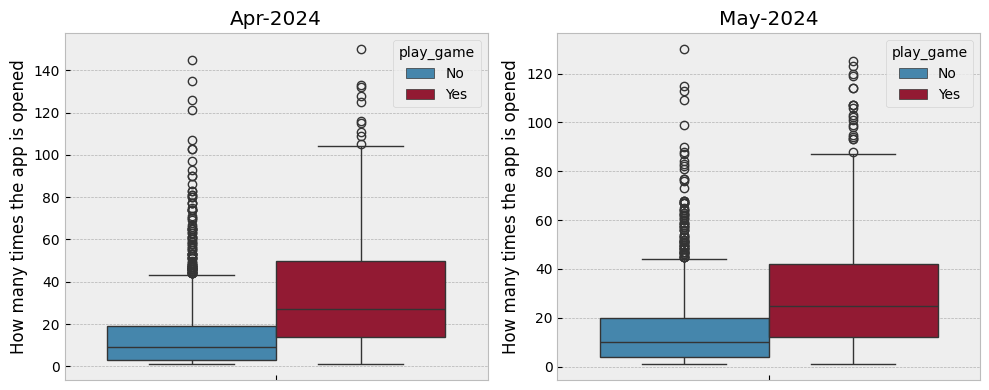

In [44]:

base_feature = 'play_game'
target_feature = 'times_open'
feature_name = "How many times the app is opened"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[full_df['snapshot_dt'] == time_].copy()
    temp_df = temp_df[temp_df.times_open>0]
    
    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : avg_session_duration
Mean Yes : 366.86
Mean No : 361.41
pval ttest = 0.27
pval ztest = 0.27

snapshot_dt : 2024-05-01
base : play_game
target : avg_session_duration
Mean Yes : 370.52
Mean No : 371.39
pval ttest = 0.538
pval ztest = 0.538



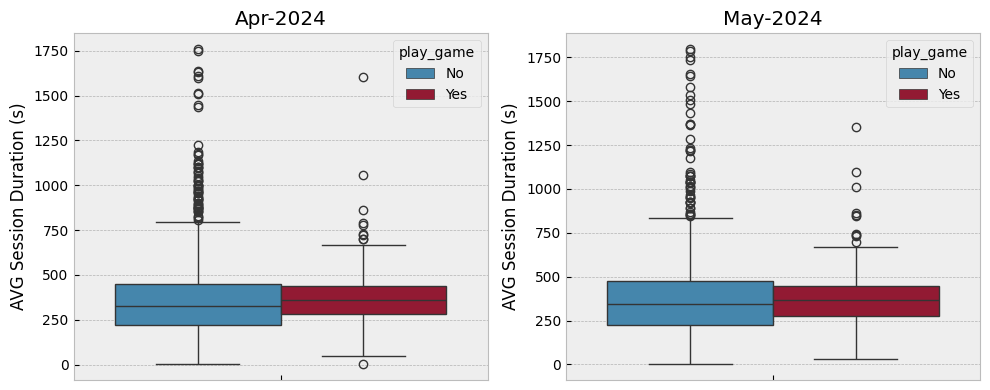

In [46]:

base_feature = 'play_game'
target_feature = 'avg_session_duration'
feature_name = "AVG Session Duration (s)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[full_df['snapshot_dt'] == time_].copy()
    temp_df = temp_df[temp_df.times_open>0]
    temp_df['avg_session_duration'] = temp_df['total_duration']/temp_df['times_open']
    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

In [14]:
s=(full_df.total_duration)/(full_df.times_open)
np.nanmean(s.values)

367.01075092293826

#### Analyze Spending Behavior

snapshot_dt : 2024-04-01
base : play_game
target : l3m_total_gmv
Mean Yes : 46551158.29
Mean No : 26881641.93
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : l3m_total_gmv
Mean Yes : 40360728.81
Mean No : 24127605.18
pval ttest = 0.0
pval ztest = 0.0



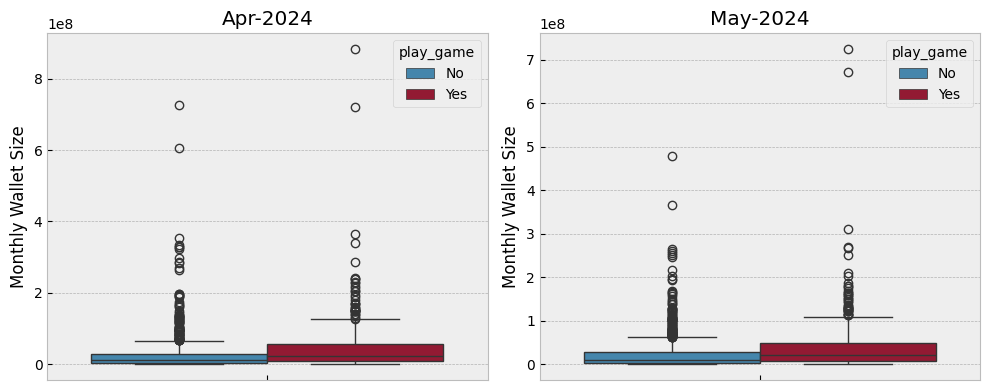

In [93]:

base_feature = 'play_game'
target_feature = 'l3m_total_gmv'
feature_name = "Monthly Wallet Size"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]

    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : l3m_total_trx
Mean Yes : 19.11
Mean No : 10.38
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : l3m_total_trx
Mean Yes : 15.64
Mean No : 9.45
pval ttest = 0.0
pval ztest = 0.0



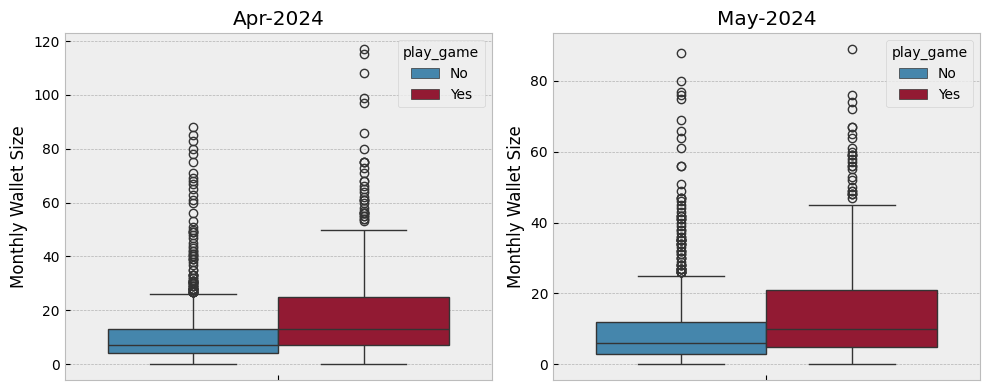

In [57]:

base_feature = 'play_game'
target_feature = 'l3m_total_trx'
feature_name = "Monthly Wallet Size"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

In [97]:
temp_df.total_gmv.sort_values()

3355       502302.0
3349       502364.0
3321       502372.0
3320       502372.0
3300       502372.0
           ...     
4070     76913574.0
3109     86804895.0
4158    107458502.0
2613    129463549.0
2908    371653976.0
Name: total_gmv, Length: 1401, dtype: float64

In [91]:
full_df[full_df.total_trx>0]

,mitra_id,cluster,label,parent_label,l3m_total_gmv,l3m_total_trx,day_open,times_open,total_duration,total_gmv_assortment,...,total_prd_assortment,total_gmv_nonassortment,total_trx_nonassortment,total_prd_nonassortment,total_trx,total_gmv,snapshot_dt,NumQuizSolved,pareto_snapshot_dt,play_game
3,34117,PRIANGAN TIMUR,AE Device,Low Value,2180480.0,2,1,2,71,650000.0,...,1,0.0,0,0,1,650000.0,2024-04-01,0.0,NaN,No
4,34065,PRIANGAN TIMUR,AE Device,Low Value,704000.0,1,1,1,1632,619430.0,...,2,0.0,0,0,1,619430.0,2024-04-01,0.0,NaN,No
5,54643,PRIANGAN TIMUR,Dependent,Potential,6084515.0,8,7,11,2168,1873630.0,...,3,0.0,0,0,1,1873630.0,2024-04-01,0.0,NaN,No
6,34247,PRIANGAN TIMUR,AE Device,Potential,4579759.0,7,1,1,95,731170.0,...,1,0.0,0,0,1,731170.0,2024-04-01,0.0,NaN,No
9,54568,BOCIMI,Independent,Big Spenders,95914703.0,28,16,30,6466,13060562.0,...,12,4045942.0,3,6,5,17106504.0,2024-04-01,0.0,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,54177,CIAYUMAJAKUNING,Independent,Potential,11060599.0,9,10,15,5897,689038.0,...,1,676378.0,1,1,1,1365416.0,2024-05-01,0.0,NaN,No
4231,34490,CIAYUMAJAKUNING,Dependent,Low Value,1809080.0,1,4,4,1017,1507260.0,...,1,0.0,0,0,1,1507260.0,2024-05-01,0.0,NaN,No
4232,25656,CIAYUMAJAKUNING,Dependent,Churn,0.0,0,1,1,486,10536438.0,...,2,0.0,0,0,1,10536438.0,2024-05-01,0.0,NaN,No
4233,42063,CIAYUMAJAKUNING,Independent,Potential,11621700.0,3,4,4,2003,1591200.0,...,1,0.0,0,0,1,1591200.0,2024-05-01,1.0,2024-05-01,Yes


snapshot_dt : 2024-04-01
base : play_game
target : total_gmv
Mean Yes : 13787948.1
Mean No : 7619097.2
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_gmv
Mean Yes : 10448269.37
Mean No : 6118687.98
pval ttest = 0.0
pval ztest = 0.0



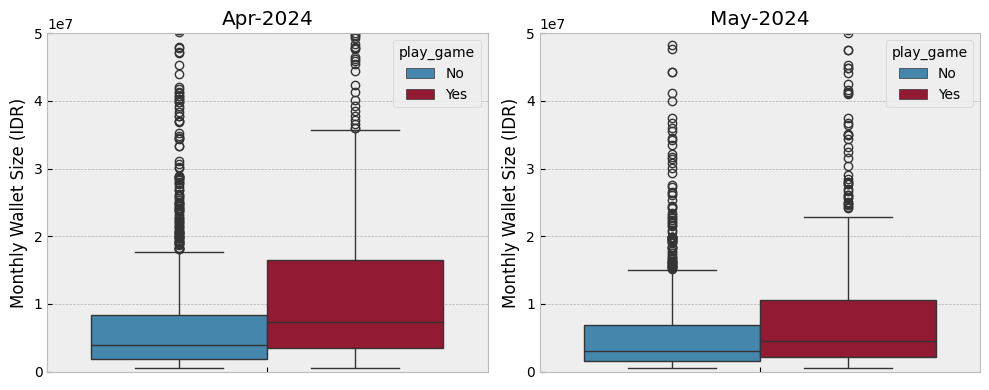

In [105]:

base_feature = 'play_game'
target_feature = 'total_gmv'
feature_name = "Monthly Wallet Size (IDR)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    ax[idx].set_ylim([0,50e+6])
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]

    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : total_trx
Mean Yes : 4.73
Mean No : 2.86
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_trx
Mean Yes : 3.43
Mean No : 2.26
pval ttest = 0.0
pval ztest = 0.0



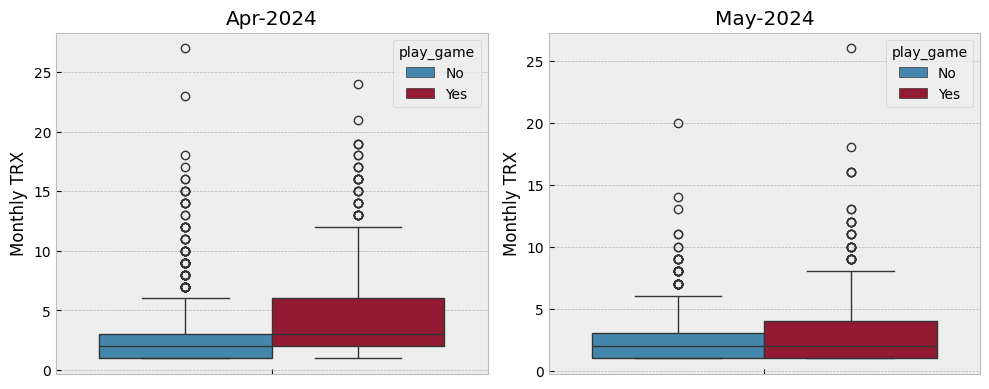

In [60]:

base_feature = 'play_game'
target_feature = 'total_trx'
feature_name = "Monthly TRX"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : total_gmv_assortment
Mean Yes : 12171295.54
Mean No : 6894923.2
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_gmv_assortment
Mean Yes : 9794739.91
Mean No : 5840479.21
pval ttest = 0.0
pval ztest = 0.0



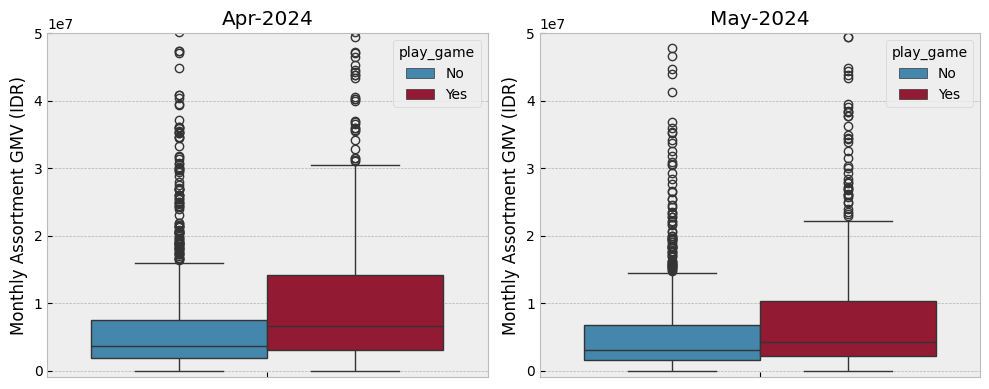

In [113]:

base_feature = 'play_game'
target_feature = 'total_gmv_assortment'
feature_name = "Monthly Assortment GMV (IDR)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    ax[idx].set_ylim([-1000000,50e+6])
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : total_trx_assortment
Mean Yes : 4.39
Mean No : 2.69
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_trx_assortment
Mean Yes : 3.34
Mean No : 2.22
pval ttest = 0.0
pval ztest = 0.0



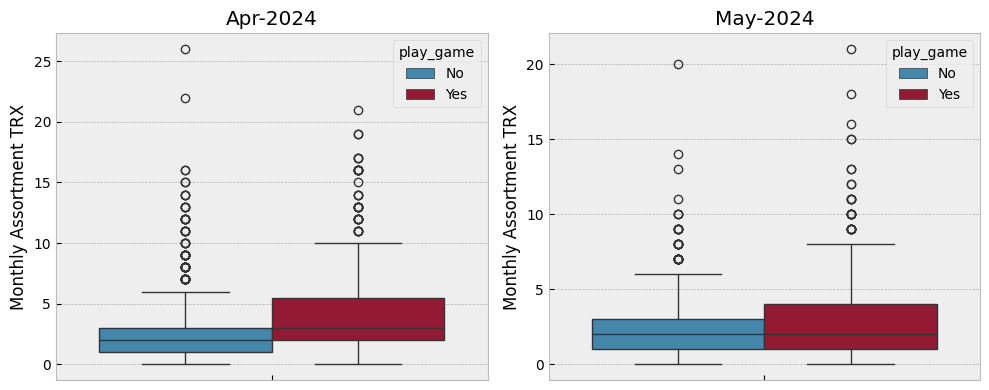

In [84]:

base_feature = 'play_game'
target_feature = 'total_trx_assortment'
feature_name = "Monthly Assortment TRX"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : total_prd_assortment
Mean Yes : 14.59
Mean No : 7.78
pval ttest = 0.0
pval ztest = 0.0

snapshot_dt : 2024-05-01
base : play_game
target : total_prd_assortment
Mean Yes : 10.8
Mean No : 6.28
pval ttest = 0.0
pval ztest = 0.0



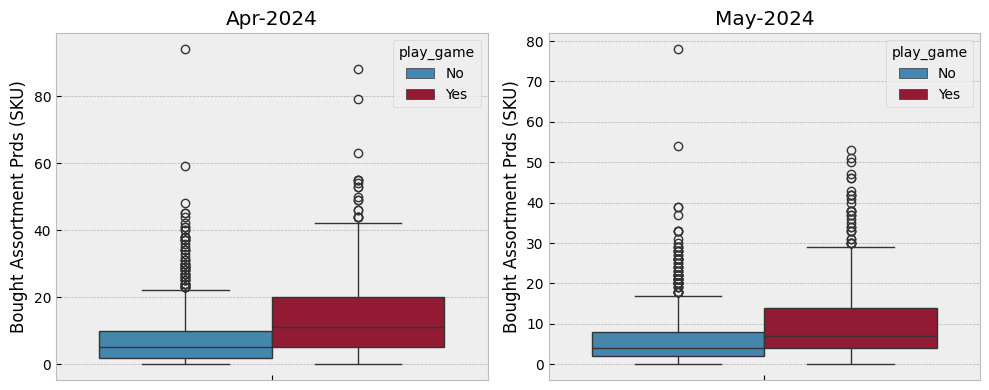

In [87]:

base_feature = 'play_game'
target_feature = 'total_prd_assortment'
feature_name = "Bought Assortment Prds (SKU)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df['total_trx'] > 0)].copy()

    
    sns.boxplot(temp_df,y=target_feature,hue=base_feature,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
    series_1 : pd.Series = temp_df[temp_df[base_feature]=='Yes'][target_feature]
    series_2 : pd.Series = temp_df[temp_df[base_feature]=='No'][target_feature]
    mean_1 : float = series_1.mean()
    print(f'Mean Yes : {np.round(mean_1,2)}')
    mean_2 : float = series_2.mean()
    print(f'Mean No : {np.round(mean_2,2)}')
    pval_t = calculate_ttest(d1 = series_1,
                          d2 = series_2)
    pval_z = calculate_ztest(d1 = series_1,
                          d2 = series_2)
    print(f"pval ttest = {np.round(pval_t,3)}")
    print(f"pval ztest = {np.round(pval_z,3)}\n")
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : is_mtu
(2.194856351317518e-36, 0.2711686438172728, 158.68299125497035, 1)


is_mtu      MTU  Non-MTU
play_game               
No         1020      645
Yes         451       42


snapshot_dt : 2024-05-01
base : play_game
target : is_mtu
(5.349164430768575e-25, 0.22658635121092208, 106.63603495089977, 1)


is_mtu     MTU  Non-MTU
play_game              
No         986      614
Yes        415       62




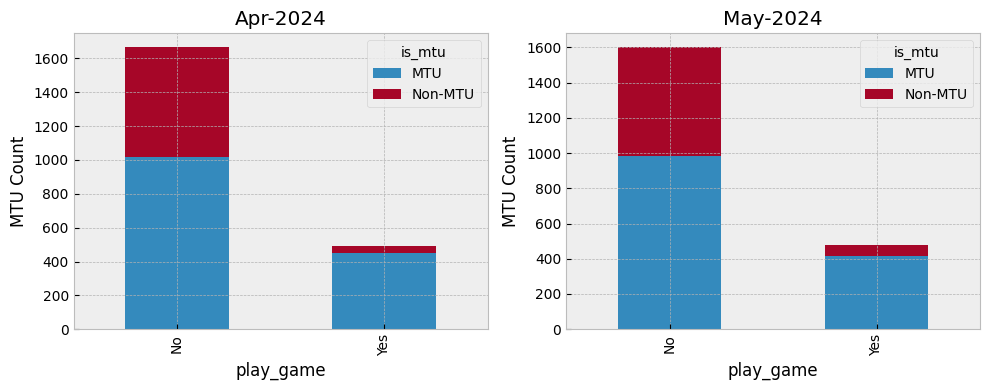

In [81]:

base_feature = 'play_game'
target_feature = 'is_mtu'
feature_name = "MTU Count"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_)].copy()
    temp_df['is_mtu'] = temp_df.total_trx.apply(lambda x: 'MTU' if x > 0 else 'Non-MTU')

    

    
    series_base : pd.Series = temp_df[base_feature]
    series_target : pd.Series = temp_df[target_feature]
    cross_df = pd.crosstab(series_base,series_target)
    
    print(calculate_chisq(series_base,series_target))
    print('\n')
    print(cross_df)
    print('\n')
    
    cross_df.plot(kind='bar',stacked=True,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
plt.tight_layout()

#### Independency and Dependency

snapshot_dt : 2024-04-01
base : play_game
target : device_kind
(3.2543641602463313e-12, 0.14995987306562422, 48.52902529743383, 1)


device_kind   AE  Non-AE
play_game               
No           459    1206
Yes           60     433


snapshot_dt : 2024-05-01
base : play_game
target : device_kind
(8.647978052519606e-10, 0.13456219892416396, 37.60820863281913, 1)


device_kind   AE  Non-AE
play_game               
No           381    1219
Yes           51     426




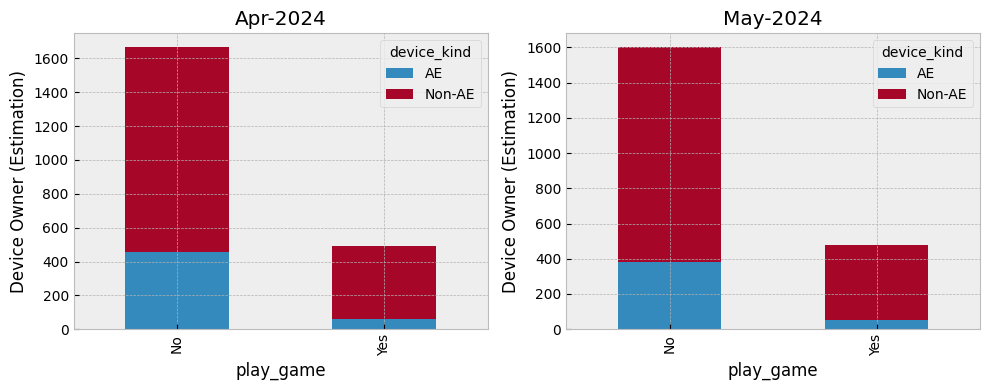

In [88]:

base_feature = 'play_game'
target_feature = 'device_kind'
feature_name = "Device Owner (Estimation)"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_)].copy()
    temp_df['device_kind'] = temp_df.label.apply(lambda x: 'AE' if x == 'AE Device' else 'Non-AE')

    

    
    series_base : pd.Series = temp_df[base_feature]
    series_target : pd.Series = temp_df[target_feature]
    cross_df = pd.crosstab(series_base,series_target)
    
    print(calculate_chisq(series_base,series_target))
    print('\n')
    print(cross_df)
    print('\n')
    
    cross_df.plot(kind='bar',stacked=True,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
plt.tight_layout()

snapshot_dt : 2024-04-01
base : play_game
target : label
(0.0286191678106214, 0.05406240402967374, 4.790376644797533, 1)


label      Dependent  Independent
play_game                        
No               509          697
Yes              156          277


snapshot_dt : 2024-05-01
base : play_game
target : label
(0.0046365921416410575, 0.06980649665415685, 8.015997774083605, 1)


label      Dependent  Independent
play_game                        
No               559          660
Yes              161          265




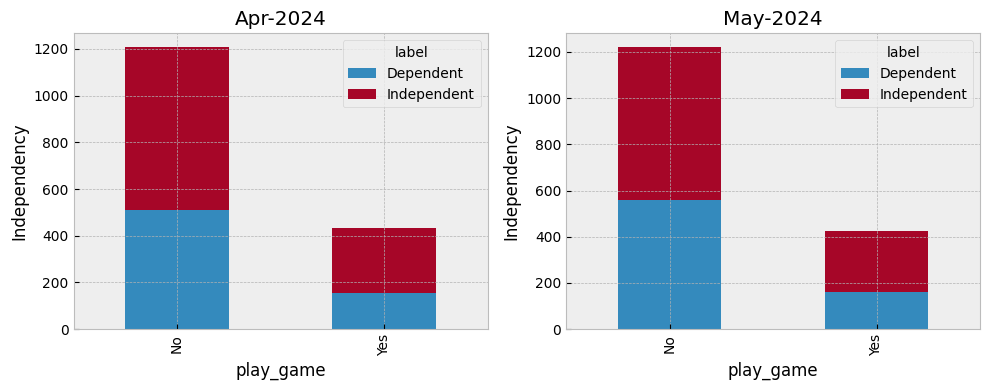

In [89]:

base_feature = 'play_game'
target_feature = 'label'
feature_name = "Independency"

fig, ax = plt.subplots(1,2,figsize = (10,4))

for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_) & (full_df.label!='AE Device')].copy()


    

    
    series_base : pd.Series = temp_df[base_feature]
    series_target : pd.Series = temp_df[target_feature]
    cross_df = pd.crosstab(series_base,series_target)
    
    print(calculate_chisq(series_base,series_target))
    print('\n')
    print(cross_df)
    print('\n')
    
    cross_df.plot(kind='bar',stacked=True,ax=ax[idx])
    ax[idx].set_title(f"{datetime.strptime(time_,'%Y-%m-%d').strftime('%b-%Y')}")
    ax[idx].set_ylabel(feature_name)
    
plt.tight_layout()

In [65]:
full_df[(full_df.snapshot_dt == '2024-04-01') & (full_df.label != 'AE Device')].value_counts('play_game')

play_game
No     1206
Yes     433
Name: count, dtype: int64

In [64]:

base_feature = 'did_play'
target_feature = 'label'


for idx,time_ in enumerate(['2024-04-01','2024-05-01']) : 
    print(f"snapshot_dt : {time_}")
    print(f"base : {base_feature}")
    print(f"target : {target_feature}")
    
    
    temp_df : pd.DataFrame = full_df[(full_df['snapshot_dt'] == time_)]
    temp_df['label'] = temp_df['label'].apply(lambda x: 'AE Device' if x == 'AE Device' else 'Non-AE Device')

    

    
    series_base : pd.Series = temp_df[base_feature]
    series_target : pd.Series = temp_df[target_feature]
    print(calculate_chisq(series_base,series_target))
    print('\n')
    print(pd.crosstab(series_base,series_target))
    print('\n')

snapshot_dt : 2024-04-01
base : did_play
target : label
(3.2543641602463313e-12, 0.14995987306562422, 48.52902529743383, 1)


label     AE Device  Non-AE Device
did_play                          
No              459           1206
Yes              60            433


snapshot_dt : 2024-05-01
base : did_play
target : label
(6.504778694012445e-10, 0.1354221838187827, 38.16380833798645, 1)


label     AE Device  Non-AE Device
did_play                          
No              389           1216
Yes              52            424




/tmp/ipykernel_133635/268700827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['label'] = temp_df['label'].apply(lambda x: 'AE Device' if x == 'AE Device' else 'Non-AE Device')
/tmp/ipykernel_133635/268700827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['label'] = temp_df['label'].apply(lambda x: 'AE Device' if x == 'AE Device' else 'Non-AE Device')


In [67]:
did_quiz_df = full_quiz_df.copy()
did_quiz_df = did_quiz_df[(did_quiz_df.label.isin(['Independent','Dependent'])) & (~did_quiz_df.parent_label.isin(['Churn','Never Transacting','Low Value']))]
did_quiz_df['dependency_label'] = did_quiz_df.label.apply(lambda x : 1 if x ==  'Independent' else 0)
did_quiz_df['total_trx'] = did_quiz_df['total_trx'].astype(float)
did_quiz_df['total_gmv'] = did_quiz_df['total_gmv'].astype(float)

cf_mod = smf.logit(formula = 'dependency_label ~ C(parent_label)  - 1',
                   data = did_quiz_df)
res = cf_mod.fit()
print(res.summary())

         Current function value: 0.624183
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       dependency_label   No. Observations:                  773
Model:                          Logit   Df Residuals:                      768
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 May 2024   Pseudo R-squ.:                 0.02389
Time:                        12:09:34   Log-Likelihood:                -482.49
converged:                      False   LL-Null:                       -494.30
Covariance Type:            nonrobust   LLR p-value:                 9.517e-05
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
C(parent_label)[At risk of churn]         0.4700      0.570      0.824      0.410      -0.

/srv/ds_project/Indra_proj/dsp_gamification_experiment/venv_gamification_experiment/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
did_quiz_df.groupby('dependency_label').NumQuizSolved.mean()

dependency_label
0    33.536398
1    44.109375
Name: NumQuizSolved, dtype: float64

In [28]:
full_df.label.value_counts()

label
Independent    1867
Dependent      1318
AE Device       930
Name: count, dtype: int64

In [30]:
did_quiz_df

,mitra_id,total_gmv,total_trx,label,parent_label,snapshot_dt,NumQuizSolved,pareto_snapshot_dt
2,34921,5.428826e+07,33,Independent,Big Spenders,2024-05-01,8.0,2024-05-01
7,49270,5.225410e+07,14,Dependent,Big Spenders,2024-05-01,48.0,2024-05-01
8,15003,2.274864e+07,12,Dependent,Potential,2024-05-01,53.0,2024-05-01
9,47234,2.246462e+07,19,Dependent,Frequent Transacting,2024-05-01,44.0,2024-05-01
10,54075,3.257732e+07,17,Independent,Big Spenders,2024-05-01,56.0,2024-05-01
...,...,...,...,...,...,...,...,...
4100,54193,2.744661e+07,28,AE Device,Big Spenders,2024-04-01,96.0,2024-04-01
4101,55349,1.552368e+08,58,Independent,Newly Joined,2024-04-01,80.0,2024-04-01
4102,33678,2.159014e+07,15,Dependent,Frequent Transacting,2024-04-01,4.0,2024-04-01
4109,29681,3.042130e+06,3,Dependent,Low Value,2024-04-01,12.0,2024-04-01
